Name: John Herrick \
Course: DSC680 \
Date: 06/20/2023

I begin by importing likely useful modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import textblob
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

I perform my initial data read.

In [2]:
df = pd.read_csv(r"C:\Users\ripva\Desktop\Masters degree stuff\DSC680\Data\Book Reviews\Books_rating.csv")
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


At three million rows and ten columns, this data set is very large. Hopefully, this glut of data will allow to create a very optimized model.

In [3]:
df.shape

(3000000, 10)

I now examine the number of missing values, or NaN's, in my data.

In [4]:
for col in df.columns:
    print(f"{col} NaN's = {df[col].isna().sum()}")

Id NaN's = 0
Title NaN's = 208
Price NaN's = 2518829
User_id NaN's = 561787
profileName NaN's = 561886
review/helpfulness NaN's = 0
review/score NaN's = 0
review/time NaN's = 0
review/summary NaN's = 38
review/text NaN's = 8


I am only really interested in the columns "review/helpfulness", "review/score", "review/summary", and "review/text". For those columns, out of 3 million rows, I have at worst a total of 46 rows with missing values. Dropping those rows will not hurt my inquiry, and I shall do that next.

In [5]:
# New dataframe is now only 46 rows shorter than it previously was and the columns I am interested in are free of NaN's.

df = df[df['review/summary'].notna()]
df = df[df['review/text'].notna()]
print(f"The length of my data frame with dropped NaN's is {len(df)} rows.")

for col in df.columns:
    print(f"{col} NaN's = {df[col].isna().sum()}")

The length of my data frame with dropped NaN's is 2999954 rows.
Id NaN's = 0
Title NaN's = 208
Price NaN's = 2518792
User_id NaN's = 561771
profileName NaN's = 561866
review/helpfulness NaN's = 0
review/score NaN's = 0
review/time NaN's = 0
review/summary NaN's = 0
review/text NaN's = 0


I write a custom function to strip the extraneous white spaces from the ends of the reviews and then apply it.

In [6]:
def strip_func(review):
    return str(review).strip()    

In [7]:
df['review/text'] = df['review/text'].apply(strip_func)

The best place to start is to convert my text values into numerical values. I can do this using TextBlob's sentiment analyzer. The sentiment of a text attempts to represent whether the sentiment is positive or negative by converting it to a float value that can range from -1 to 1, with anything over zero being positive and anything under zero being negative. -1 is the strongest possible negative sentiment and 1 is the strongest possible positive sentiment. Before I can perform a sentiment analysis on the text I must perform transform the text into question into a blob object. I do that below, creating a new column to hold the converted review text.

In [8]:
df['review/blob'] = df['review/text'].apply(lambda x: textblob.TextBlob(x))

Now I will carry out the very time-consuming process of converting the blob objects into sentiment scores. I create a new column to hold these scores for their associated reviews.

In [14]:
df.drop('profileName', inplace = True, axis = 1)

In [ ]:
df['review/sentiment'] = df['review/blob'].apply(lambda x: x.sentiment.polarity)

I am also interested to see how these sentiment scores compare to the actual review scores. In order to compare them I will have to bin the sentiment scores into 5 different categories so that they will be compatible with the 1-5 review scores scale. I create a custom function to carry this out and apply it.

In [ ]:
def sent_score_converter(sentiment):
    if sentiment >= 0.6:
        return 5
    elif 0.6 > sentiment >=0.2:
        return 4
    elif 0.2 > sentiment >= -0.2:
        return 3
    elif -0.2 > sentiment >= -0.6:
        return 2
    elif -0.6 > sentiment >= -1:
        return 1
    else:
        print(f"Error occured with {sentiment}.")

In [ ]:
df['sentiment_score'] = df['review/sentiment'].apply(sent_score_converter)

I now carry out the process of turning the review summaries into blob objects. I store these blob objects in a new column.

In [ ]:
df['review/summary/blob'] = df['review/summary'].apply(lambda x: textblob.TextBlob(x))

Having carried out the transformation of the review summaries text into blob objects, I now convert them into sentiment scores. I create a new column to keep these scores with their associated reviews.

In [ ]:
df['review/summary/sentiment'] = df['review/summary/blob'].apply(lambda x: x.sentiment.polarity)

In order to use the "review/helpfulness" column I must transform its values. As they exist presently they are merely string representations of arbitrary ratios (e.g., 1/3, 7/7, 4/5) and so, in order to use them, I will convert them into their decimal equivalents. I create a custom function below to split the string on '/', convert the two string representations of numbers into integers, and then carry out the division between those numbers. I follow up by applying it to my data and creating a new column to hold the resulting value. Due to a ZeroDivisionError emerging, I've had to catch that problem with a try/except block and I manually set the values that trigger this error to '0'.

In [ ]:
def string_to_float_converter(score):
    item, item2 = score.split('/')
    try: 
        float_score = int(item)/int(item2)
    except ZeroDivisionError:
        float_score = 0
    return float_score

In [ ]:
df['review/helpfulness/float'] = df['review/helpfulness'].apply(string_to_float_converter)

Out of curiousity I examined just how many values scores divided by zero, and I also examined how many unique instances of this value there were. It turns out there was surprisingly only one unique value ('0/0'), but it did occur a staggering 885,715 times. This is actually fine, however, since 0 is a fine representation of the intentions of persons who give a score of '0/0', and so it does not distort the final score at all.

In [16]:
div_by_zero_total = 0
div_by_zero_list = []

for score in df['review/helpfulness']:
    item, item2 = score.split('/')
    try: 
        float_score = int(item)/int(item2)
    except ZeroDivisionError:
        float_score = 0
        div_by_zero_total += 1
        div_by_zero_list.append(score)
print(f"The total number of instances where divide by zero occurred was {div_by_zero_total}.")

The total number of instances where divide by zero occurred was 885715.


Showing that there was only one unique value triggering this error, and that it was functionally equivalent to '0' for my purposes.

In [17]:
set(div_by_zero_list)

{'0/0'}

Examining the distribution of mean review helpfulness decimal scores versus their associated review scores. This shows that they are fairly evenly distributed, at least as far as their mean values goes. This is interesting; apparently, reviews of all levels had similar degrees of mean utility to others.

In [18]:
df.groupby('review/score')['review/helpfulness/float'].mean()

review/score
1.0    0.421449
2.0    0.448497
3.0    0.437238
4.0    0.486673
5.0    0.513665
Name: review/helpfulness/float, dtype: float64

Examining the total number of '0' review helpfulness scores and I find it to be quite high, though given the number of divide by zero scores I had earlier that isn't surprising.

In [19]:
(df['review/helpfulness/float'] == 0).sum()

1109623

Examining the spread of '0' review helpfulness decimal scores, I see that they are spread between the review scores in a distribution that strongly leans towards the higher end of the review score scale. Examining the graph, it looks as though it may be exponential. Once I start examining my other data distributions graphically I can see what this means.

In [20]:
df[df['review/helpfulness/float']==0].groupby('review/score')['review/helpfulness/float'].count()

review/score
1.0     34689
2.0     37550
3.0     92463
4.0    238454
5.0    706467
Name: review/helpfulness/float, dtype: int64

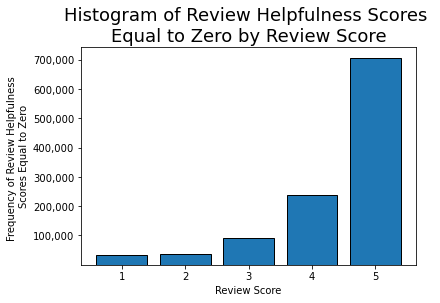

In [21]:
plt.bar(df[df['review/helpfulness/float']==0].groupby('review/score')['review/helpfulness/float'].count().index
        , df[df['review/helpfulness/float']==0].groupby('review/score')['review/helpfulness/float'].count(), 
        edgecolor = 'black')
plt.xlabel('Review Score')
plt.ylabel('Frequency of Review Helpfulness \nScores Equal to Zero')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [100000, 200000, 300000, 400000, 500000, 600000, 700000], 
           labels = ['100,000', '200,000', '300,000', '400,000', '500,000', '600,000', '700,000'])
plt.title("Histogram of Review Helpfulness Scores \nEqual to Zero by Review Score", size = 18)
plt.show()

Splitting my data into training, validation, and test chunks for future steps. The training block will be used for the bulk of the work, with validation existing only to allow for fine tuning of models or comparisons between models, and the testing block shall be held out until the end to demonstrate generalizable results. The split of the data is 0.5/0.25/0.25 for training/validation/testing respectively.

In [15]:
features = df.drop('review/score', axis = 1)
target = df['review/score']
features_train, features_val, target_train, target_val = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size = 0.50, 
                                                                                  random_state = 1, 
                                                                                  stratify = target)
features_val, features_holdout, target_val, target_holdout = train_test_split(features_val, target_val,
                                                                              test_size = 0.5,
                                                                              random_state = 1,
                                                                              stratify = target_val)
features_train.head()

,index,Id,Title,Price,User_id,review/helpfulness,review/time,review/summary,review/text,review/blob,review/sentiment,sentiment_score,review/summary/blob,review/summary/sentiment,review/helpfulness/float
285371,285374,0262121417,Realistic Compiler Generation (Foundations of ...,NaN,A1YX0YVSHVYTCY,1/1,1072656000,Excellent book on a very complex subject.,This is a wonderful book. Perfectly balanced i...,"(T, h, i, s, , i, s, , a, , w, o, n, d, e, ...",0.326389,4,Excellent book on a very complex subject.,0.147778,1.0
2839272,2839317,B0000CJ9GZ,The richest man in Babylon,NaN,NaN,0/1,1000512000,Good basic personal finance.,Some good tips on building a nest egg and payi...,"(S, o, m, e, , g, o, o, d, , t, i, p, s, , ...",0.700000,5,Good basic personal finance.,0.233333,0.0
39092,39092,0738703125,How to be a Ghost Hunter (How To Series),10.35,A1SSC4179O5I8G,0/0,1307577600,THIS IS A GOOD ONE..!!,"A GOOD BOOK TO HAVE IF YOU ARE GHOST HUNTING, ...","(A, , G, O, O, D, , B, O, O, K, , T, O, , ...",0.475000,4,THIS IS A GOOD ONE..!!,1.000000,0.0
974288,974298,1566195683,The brothers Karamazov (Barnes & Noble classics),NaN,NaN,1/2,855100800,Don't Be Fooled By The &quot;Classic&quot; lab...,For every person who makes it a point to read ...,"(F, o, r, , e, v, e, r, y, , p, e, r, s, o, ...",0.198810,3,Don't Be Fooled By The &quot;Classic&quot; lab...,0.000000,0.5
1207484,1207496,0670036102,Singing the Dogstar Blues,NaN,NaN,3/3,1075766400,Singing The Dogstar Blues,Aliens. Aliens from a distant planet have land...,"(A, l, i, e, n, s, ., , A, l, i, e, n, s, , ...",0.071528,3,Singing The Dogstar Blues,0.000000,1.0


In [16]:
# Converting target_train data into a single-column dataframe.

target_train = pd.DataFrame(target_train)
target_train.head()

,review/score
285371,4.0
2839272,5.0
39092,5.0
974288,5.0
1207484,4.0


# Graphical Analysis of my Features and Target {-}

The following visualizations in this section, where not specifically noted, are for the entirety of my dataset, not just one particular partition (i.e., training, validation, or testing). I begin by graphically examining the distribution of my target data: review scores. Per the frequency distribution below, the graph skews heavily towards higher values, with the result of 5 being more than half of all values.

In [24]:
df['review/score'].value_counts()

5.0    1807315
4.0     585606
3.0     254293
1.0     201687
2.0     151053
Name: review/score, dtype: int64

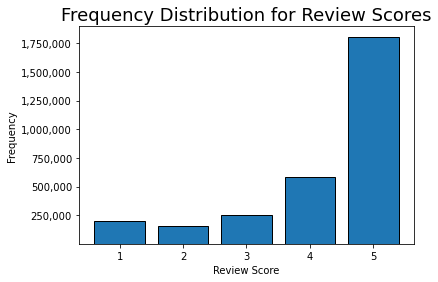

In [25]:
# In order to get the bars to line up over the xticks, I decided to create a bar graph that showed the value counts per 
# value for the review scores.

plt.bar([5,4,3,1,2], df['review/score'].value_counts(), edgecolor = 'black')
plt.title("Frequency Distribution for Review Scores", size = 18)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000], 
          labels = ['250,000', '500,000', '750,000', '1,000,000', '1,250,000', '1,500,000', '1,750,000'])
plt.show()

Below I check to ensure the distribution of the target data in the training block roughly approximates the distribution in the overall dataset. It does.

In [26]:
target_train.value_counts()

review/score
5.0             903658
4.0             292803
3.0             127146
1.0             100843
2.0              75527
dtype: int64

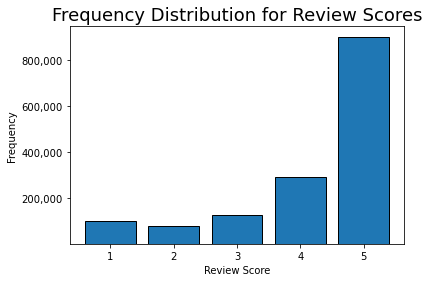

In [27]:
plt.bar([5,4,3,1,2], target_train.value_counts(), edgecolor = 'black')
plt.title("Frequency Distribution for Review Scores", size = 18)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [200000, 400000, 600000, 800000], labels = ['200,000', '400,000', '600,000', '800,000'])
plt.show()

Below, I check to see if the text reviews converted by TextBlob into sentiment scores match the above distributions. The actual sentiment scores were actually floats ranging from -1.0 to 1.0; in order to create scores that were in the 1-5 ranking scale, I simply divided the sentiment score range into five equal bins and assigned the score of 1-5 based on which bin the sentiment score fell into. As can be seen, the distribution drastically over-represents categories '3' and '4', severly under-represents category '5', and somewhat under-represents all other categories. This very simplistic model does not seem to be very accurate, though I'll compute an actual accuracy score on this later.

In [28]:
df['sentiment_score'].value_counts()

3    1506631
4    1337029
5     111623
2      40724
1       3947
Name: sentiment_score, dtype: int64

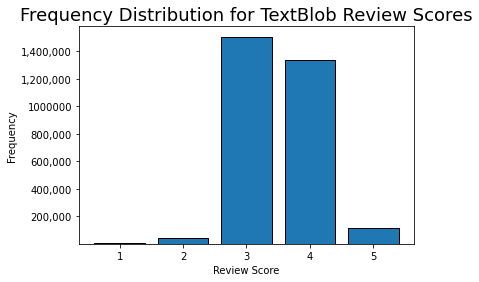

In [29]:
plt.bar([3,4,5,2,1], df['sentiment_score'].value_counts(), edgecolor = 'black')
plt.title("Frequency Distribution for TextBlob Review Scores", size = 18)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [200000, 400000, 600000, 800000, 1000000, 1200000, 1400000], 
           labels = ['200,000', '400,000', '600,000', '800,000', '1000000', '1,200,000', '1,400,000'])
plt.show()

The sentiment scores, when not binned into one of five chunks, still maintains a similar distribution though with obviously greater granularity in their resolution. It seems to strongly favor slightly to somewhat favorable reviews (hence its earlier over-represenation of the '3' and '4' categories), with a positive mean. The majority of the values are focused in the aforementioned categories, thus causing the graph to be strongly leptokurtic.

In [30]:
df['review/sentiment'].describe()

count    2.999954e+06
mean     2.104707e-01
std      1.945261e-01
min     -1.000000e+00
25%      9.634522e-02
50%      1.931902e-01
75%      3.100000e-01
max      1.000000e+00
Name: review/sentiment, dtype: float64

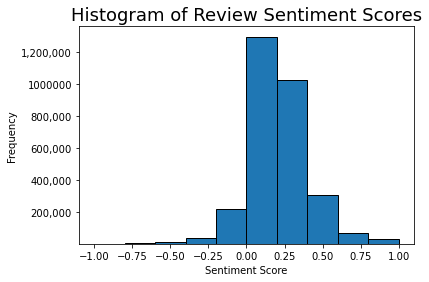

In [31]:
plt.hist(df['review/sentiment'], edgecolor = 'black')
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [200000, 400000, 600000, 800000, 1000000, 1200000], 
           labels = ['200,000', '400,000', '600,000', '800,000', '1000000', '1,200,000'])
plt.title("Histogram of Review Sentiment Scores", size = 18)
plt.show()

The following graph examines the TextBlob sentiment score distributions for the 'review/summary' column. This column contains a "too long didn't read" (TLDR) version of the actual text review. As can be seen, this distribution is unlike the others in that it tends to show an almost linear positive slop throughout except for the obvious surge of values in the center of the graph. This shows that the review summaries carry a different type of sentiment information than the textual reviews themselves. This will have its mean on the positive side of the spectrum, showing a tendancy for favoring positive sentiments.

In [32]:
df['review/summary/sentiment'].describe()

count    2.999954e+06
mean     2.489615e-01
std      4.061598e-01
min     -1.000000e+00
25%      0.000000e+00
50%      8.333333e-02
75%      5.000000e-01
max      1.000000e+00
Name: review/summary/sentiment, dtype: float64

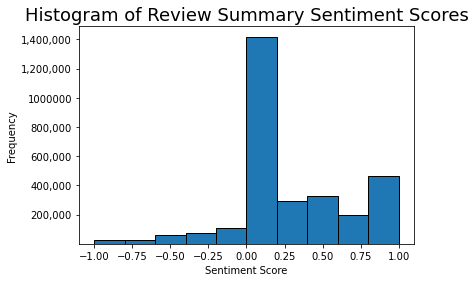

In [33]:
plt.hist(df['review/summary/sentiment'], edgecolor = 'black')
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [200000, 400000, 600000, 800000, 1000000, 1200000, 1400000], 
           labels = ['200,000', '400,000', '600,000', '800,000', '1000000', '1,200,000', '1,400,000'])
plt.title("Histogram of Review Summary Sentiment Scores", size = 18)
plt.show()

The next and final graph shows the distribution of the review helpfulness scores. For every review there is a colum that allows users to input a numbered ratio to express how useful the review was. Since there was no standard for the denominator in these ratios (e.g., 7/8, 3/4, 5/5) I used a custom function to split the ratios on the '/' character, convert the string representations of numbers into integers, and then carried out the division implied by the ratio to create a single float value to allow for direct comparison between these scores. Although one would assume that the best score would be '1' given that any ratio score mechanism would allow for only as many points as there were to give in the scale (i.e., 5 out of 5 stars or 5/5), it would seem that some users decided to allow for larger numerators than the denominators they gave. These occurrunces are sufficiently rare that although their presence pulls the x-axis of the graph to the right, there doesn't seem to be enough of them to register as visible bars. It seems like the most common score for a review is one that is considered to be unhelpful, followed next by reviews that are considered very helpful, and then a moderate distribution of values in between (the absurdly high values don't factor in as they are so few they don't even register visually on the graph). This preponderance of low scores is in part due to the large number of '0/0' scores I found earlier, which actually make up approximately three quarters of value-counts in the largest bar in graph below.

In [34]:
df['review/helpfulness/float'].describe()

count    2.999954e+06
mean     4.924365e-01
std      4.309185e-01
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e-01
75%      1.000000e+00
max      3.000000e+00
Name: review/helpfulness/float, dtype: float64

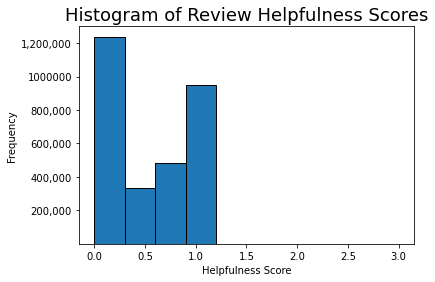

In [35]:
plt.hist(df['review/helpfulness/float'], edgecolor = 'black')
plt.xlabel('Helpfulness Score')
plt.ylabel('Frequency')
plt.ticklabel_format(style = 'plain')
plt.yticks(ticks = [200000, 400000, 600000, 800000, 1000000, 1200000], 
           labels = ['200,000', '400,000', '600,000', '800,000', '1000000', '1,200,000'])
plt.title("Histogram of Review Helpfulness Scores", size = 18)
plt.show()

Before I begin assessing the data with more rigorous models, I will first assess the raw accuracy of the TextBlob sentiment scores as converted to a 1-5 review score scale. As can be seen, it is very low.

In [36]:
print(f"The accuracy of the TextBlob sentiments as converted to a 1-5 score is "\
      f"{round(accuracy_score(features_train['sentiment_score'], target_train)*100, 2)}%.")

The accuracy of the TextBlob sentiments as converted to a 1-5 score is 17.44%.


I now create my desired feature set, which is only the numerical columns derived from the TextBlob analysis of the textual reviews, their summaries, and the numerical conversion of helpfulness scores into decimal values. I left out the TextBlob sentiment scores as converted to a 1-5 score scale as that was simply converting high resolution data to low resolution data and so would not help me. 

# Model Creation {-}

In [17]:
features_train_textblob = features_train[['review/sentiment', 
                                          'review/summary/sentiment', 
                                          'review/helpfulness/float']]
features_val_textblob = features_val[['review/sentiment', 
                                      'review/summary/sentiment', 
                                      'review/helpfulness/float']]
features_holdout_textblob = features_holdout[['review/sentiment', 
                                              'review/summary/sentiment', 
                                              'review/helpfulness/float']]

I create a pipeline to assess a random forest classifier as a means of prediction that can outperform the TextBlob sentiment scores converted to a 1-5 score scale. I try out several n_estimators, and given the staggering size of my data I have lowered the number of cv partitions from my usual 5 to 4 to avoid running into a memory error (this has occurred several times throughout my work due to the large number of rows I am working with). I also had to remove the n_jobs = -1 parameter as that was causing memory errors as well. Without setting n_jobs to -1, that's all the more reason to cut down on the cross validation partitions as the run-time is already going to be lengthy.

In [38]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state = 1))])

search_space = [{'classifier': [RandomForestClassifier(random_state =1)],
                'classifier__n_estimators': [100, 200, 250, 300, 350], 
                'classifier__max_features': ['sqrt']}]
classifier = GridSearchCV(pipe, search_space, cv = 4).fit(features_train_textblob, target_train.values.ravel())
classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   RandomForestClassifier(max_features='sqrt', n_estimators=300, random_state=1))],
 'verbose': False,
 'classifier': RandomForestClassifier(max_features='sqrt', n_estimators=300, random_state=1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': 1,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [39]:
# The accuracy of the model on the training data was as follows.

results_blob = classifier.predict(features_train_textblob)
print(f"The accuracy of the random forest classifier with only an initial tuning of the n_estimators hyperparameter was "\
      f"{round(accuracy_score(results_blob, target_train)*100, 2)}%.")

The accuracy of the random forest classifier with only an initial tuning of the n_estimators hyperparameter was 89.69%.


I wanted to examine just how the model was achieving its accuracy numbers, and we see below that for all predicted values other than '5' the model is very accurate with a slight preference for predicting '5' over other values, but given that the data was imbalanced towards review scores of '5' this is not surprising. Even this slight imbalance in the predictions of the model is neglible given the magnitude of its correct and incorrect predictions with these values. When it comes to predictions of '5', however, we see that while it is extremely accurate, the highest category of its misses in this category are for the adjancent value of '4', which is to say that when it does miss it doesn't tend to miss by much. Of the remaining three categories for mis-predictions when it comes to predicting the value of '5', we see that it favors '3' as its next most favored value, which makes sense as that is closer to '5' than its other options at that point, and then it splits its errors fairly evently between '1' and '2'. 

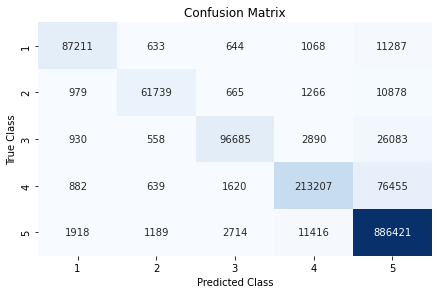

In [40]:
class_names = [1,2,3,4,5]

target_predicted = classifier.predict(features_train_textblob)

matrix = confusion_matrix(target_train, target_predicted)

dataframe = pd.DataFrame(matrix, index = class_names, columns = class_names)

sns.heatmap(dataframe, annot = True, cbar = None, cmap ='Blues', fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout(),
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [41]:
# Checking the accuracy of the model on the validation data set.

results_val = classifier.predict(features_val_textblob)
accuracy_val = accuracy_score(results_val, target_val)
print(f"The accuracy of the random forest classifier model on the validation data is {round(accuracy_val *100, 2)}%.")

The accuracy of the random forest classifier model on the validation data is 66.39%.


Although my validation data accuracy is not as high as I would like, it is still better than the accuracy achievable by baseline guessing (i.e., guessing all values were the dominant class, '5'). In the next cell I create a confusion matrix for this data, and find that the accuracy across the board is diminished, with a tendancy to favor "5"s when selecting the wrong value. Given the imbalance in the dataset this is not very suprising. 

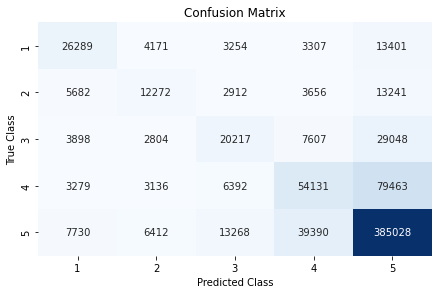

In [42]:
# Creating a confusion matrix for the results of applying the model to the validation data.

target_predicted_val = classifier.predict(features_val_textblob)

matrix = confusion_matrix(target_val, target_predicted_val)

data_frame = pd.DataFrame(matrix, index = class_names, columns = class_names)
sns.heatmap(data_frame, annot = True, cmap = 'Blues', cbar = None, fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Given that model performs so much better on the training data than the validation data, it seems that my model is overfit. It may be the case that the complexity of linguistic data is more than my model can grapple with at high levels of accuracy, but it may also be the case that the random forest classifier has simply allowed itself to grow too deep. In the following cells I try to iteratively optimize my model based on tree depth. I would ordinarily simply add the max depth to the grid search, but with the memory issues I'm experienceing I may have to do this one step at a time with an isolated grid search each time.

Before I iterate over the models, I demonstrate the mean depths of a random forest classifier with the pertinent hyperparameters, which guides my selection of different max depths to try.

In [27]:
rf = RandomForestClassifier(n_estimators = 300)
model = rf.fit(features_train_textblob, target_train.values.ravel())

In [28]:
depths = [tree.tree_.max_depth for tree in model.estimators_]
total = 0
for item in depths:
    total+=item
print(f"The mean tree depth in the random forest classifier is {total/len(depths)}.")    

The mean tree depth in the random forest classifier is 98.54666666666667.


In [18]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state = 1))])

search_space = [{'classifier': [RandomForestClassifier(random_state =1)],
                'classifier__n_estimators': [100, 200, 250, 300, 350], 
                'classifier__max_features': ['sqrt'],
                'classifier__max_depth': [8]}]
classifier2 = GridSearchCV(pipe, search_space, cv = 4).fit(features_train_textblob, target_train.values.ravel())
classifier2.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=350,
                          random_state=1))],
 'verbose': False,
 'classifier': RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=350,
                        random_state=1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 350,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': 1,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [22]:
results2 = classifier2.predict(features_train_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 8 was "\
      f"{round(accuracy_score(results2, target_train)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 8 was 62.34%.


In [23]:
results_val2 = classifier2.predict(features_val_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 8 was "\
      f"{round(accuracy_score(results_val2, target_val)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 8 was 62.27%.


In the next iteration I try increasing the max depth to 50 to see how that impacts the results.

In [20]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state = 1))])

search_space = [{'classifier': [RandomForestClassifier(random_state =1)],
                'classifier__n_estimators': [100, 200, 250, 300, 350], 
                'classifier__max_features': ['sqrt'],
                'classifier__max_depth': [50]}]
classifier3 = GridSearchCV(pipe, search_space, cv = 4).fit(features_train_textblob, target_train.values.ravel())
classifier3.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=300,
                          random_state=1))],
 'verbose': False,
 'classifier': RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=300,
                        random_state=1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 50,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': 1,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [21]:
results3 = classifier3.predict(features_train_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 50 was "\
      f"{round(accuracy_score(results3, target_train)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 50 was 89.47%.


In [22]:
results_val3 = classifier3.predict(features_val_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 50 was "\
      f"{round(accuracy_score(results_val3, target_val)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 50 was 66.5%.


In the following iteration I try a max depth of 75. The final result is that there is no improvement over not controlling for the depth. After this I shall move on to a different optimization tactic.

In [18]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state = 1))])

search_space = [{'classifier': [RandomForestClassifier(random_state =1)],
                'classifier__n_estimators': [100, 200, 250, 300, 350], 
                'classifier__max_features': ['sqrt'],
                'classifier__max_depth': [75]}]
classifier4 = GridSearchCV(pipe, search_space, cv = 4).fit(features_train_textblob, target_train.values.ravel())
classifier4.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   RandomForestClassifier(max_depth=75, max_features='sqrt', n_estimators=300,
                          random_state=1))],
 'verbose': False,
 'classifier': RandomForestClassifier(max_depth=75, max_features='sqrt', n_estimators=300,
                        random_state=1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 75,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': 1,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [19]:
results4 = classifier4.predict(features_train_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 75 was "\
      f"{round(accuracy_score(results4, target_train)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 75 was 89.69%.


In [20]:
results_val4 = classifier4.predict(features_val_textblob)
print(f"The accuracy of the random forest classifier with a max depth of 75 was "\
      f"{round(accuracy_score(results_val4, target_val)*100, 2)}%.")

The accuracy of the random forest classifier with a max depth of 75 was 66.41%.


As I mentioned earlier, there wasn't substantial improvement despite the tuning.

Seeing the above results for the random forest classifier, I then decided to try a multinomial naive Bayes classifier. Since the multinomial naive Bayes classifier cannot accept negative values and my sentiment scores range from -1 to 1, I need to employ MinMaxScaler to change my values into strictly positive data while maintaining the information the differences in the values contain. I would ordinarily just include the naive Bayes model in the earlier grid searches, but memory errors prevent me from doing anything so robust. Instead, I simply carry it out below.

In [22]:
# Scaling data so that I have the appropriate data for the naive Bayes classifier (it cannot tolerate negatives).

scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train_textblob)
features_val_scaled = scaler.transform(features_val_textblob)

In [25]:
# Building actual model.

classifier5 = MultinomialNB()
classifier5.fit(features_train_scaled, target_train.values.ravel())

MultinomialNB()

Unfortunately the accuracy of the naive Bayes classifier is substantially lower than the random forest classifier on the training data, however its results on the validation data are so similar to the training data that it seems that it was not subject to the same overfitting that affected the random forest classifier. That being said, neither of its accuracy results were better than the random forest classifier so I will not be pursuing this type of classifier any further.

In [26]:
results_nb = classifier5.predict(features_train_scaled)
accuracy_score(results_nb, target_train)

0.6024479042011978

In [27]:
results_nb_val = classifier5.predict(features_val_scaled)
accuracy_score(results_nb_val, target_val)

0.6024469724848931

Given that my data shows an imbalance towards the target value of "5", I've decided that perhaps I can overcome the overfitting in my random forest model by pruning out some of the excess data pertaining to the "5"s. To this end I will employ random undersampling. I would ordinarily attempt to pair this with SMOTE (synthetic minority oversampling technique), but the size of my data is already at the edge of what my software can handle, so I need to avoid creating any more data. Also, given the complexity of linguistic data, I doubt whether SMOTE could synthesize reliable data points as opposed to just creating noisy data.

In [18]:
# Rebuilding my feature and target data partitions from the undersampled data.

rus = RandomUnderSampler(random_state = 1, sampling_strategy = 'majority')

df_rus, target_rus = rus.fit_resample(df, target)

target_rus = df_rus['review/score']
features_rus = df_rus.drop('review/score', axis = 1)



features_train_rus, features_val_rus, target_train_rus, target_val_rus = train_test_split(features_rus, 
                                                                                  target_rus, 
                                                                                  test_size = 0.50, 
                                                                                  random_state = 1, 
                                                                                  stratify = target_rus)
features_val_rus, features_holdout_rus, target_val_rus, target_holdout_rus = train_test_split(features_val_rus, target_val_rus,
                                                                              test_size = 0.5,
                                                                              random_state = 1,
                                                                              stratify = target_val_rus)
features_train_rus_textblob = features_train_rus[['review/sentiment', 
                                          'review/summary/sentiment', 
                                          'review/helpfulness/float']]
features_val_rus_textblob = features_val_rus[['review/sentiment', 
                                              'review/summary/sentiment', 
                                              'review/helpfulness/float']]
features_holdout_rus_textblob = features_holdout_rus[['review/sentiment', 
                                              'review/summary/sentiment', 
                                              'review/helpfulness/float']]

Converting the target data into a dataframe. Checking the value counts of the target data to see the new distribution. It looks as though the '5' data is now in line with the '2' data in terms of size.

In [19]:
target_train_rus = pd.DataFrame(target_train_rus)
target_train_rus.groupby('review/score').value_counts()

review/score
1.0    100843
2.0     75526
3.0    127147
4.0    292803
5.0     75527
dtype: int64

Running another grid search to fit the optimal model hyperparameters onto the undersampled data.

In [20]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state = 1))])

search_space = [{'classifier': [RandomForestClassifier(random_state =1)],
                'classifier__n_estimators': [100, 200, 250, 300, 350], 
                'classifier__max_features': ['sqrt']}]
classifier_rus = GridSearchCV(pipe, search_space, cv = 4).fit(features_train_rus_textblob, target_train_rus.values.ravel())
classifier_rus.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier',
   RandomForestClassifier(max_features='sqrt', n_estimators=300, random_state=1))],
 'verbose': False,
 'classifier': RandomForestClassifier(max_features='sqrt', n_estimators=300, random_state=1),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 300,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': 1,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [21]:
results_rus = classifier_rus.predict(features_train_rus_textblob)
print(f"The accuracy of the undersampled random forest classifier on the training data was "\
      f"{round(accuracy_score(results_rus, target_train_rus)*100, 2)}%.")

The accuracy of the undersampled random forest classifier on the training data was 89.16%.


In [22]:
results_rus_val = classifier_rus.predict(features_val_rus_textblob)
print(f"The accuracy of the undersampled random forest classifier on the validation data was "\
      f"{round(accuracy_score(results_rus_val, target_val_rus)*100, 2)}%.")

The accuracy of the undersampled random forest classifier on the validation data was 55.08%.


After all of my optimization attempts, it seems that the random forest classifier is performing as well as it can. I shall now try it on the holdout (or test) data partition to see what my final, generalizable results are.

# Final Results {-}

In [44]:
results_test_blob = classifier.predict(features_holdout_textblob)
print(f"The accuracy of the original random forest classifier on the holdout (test) data was "\
      f"{round(accuracy_score(results_test_blob, target_holdout)*100, 2)}%.")

The accuracy of the original random forest classifier on the holdout (test) data was 66.38%.


I present the confusion matrix for the final model's results on the holdout data below, and find it to be very similar to the validation data. This is not surprising.

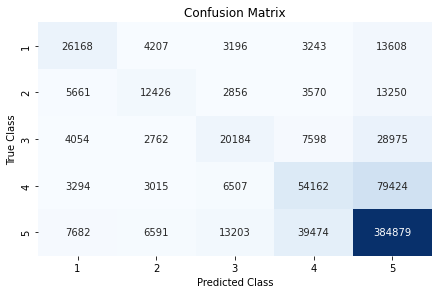

In [45]:
class_names = [1,2,3,4,5]

target_predicted = classifier.predict(features_holdout_textblob)

matrix = confusion_matrix(target_holdout, target_predicted)

dataframe = pd.DataFrame(matrix, index = class_names, columns = class_names)

sns.heatmap(dataframe, annot = True, cbar = None, cmap ='Blues', fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout(),
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()